# analytical approach

- analytically tractable problem: Gaussian prior, Gaussian proposal, _linear-Gaussian likelihood_
- analytically tractable MDN: linear-affine network
- analytically tractable gradients and closed-form solution for MDN parameters for given dataset


TO DO:
- check gradients again (and again and again...)
- analytical division for actual CDELDI posterior estimates (vs. 'proposal-posterior' estimates atm)


prior: 

$p(\theta) = \mathcal{N}(\theta \ | \ 0, \eta^2)$

proposal prior: 

$\tilde{p}(\theta) = \mathcal{N}(\theta \ | \ \nu, \xi^2)$

simulator: 

$p(x \ | \ \theta) =  \mathcal{N}(x \ | \ \theta, \sigma^2)$

analytic posteriors: 

$p(\theta \ | \ x) = \mathcal{N}(\theta \ | \frac{\eta^2}{\eta^2 + \sigma^2} x, \eta^2 - \frac{\eta^4}{\eta^2 + \sigma^2})$ 

$\tilde{p}(\theta \ | \ x) = \mathcal{N}(\theta \ | \frac{\xi^2}{\xi^2 + \sigma^2} x + \frac{\sigma^2}{\xi^2 + \sigma^2} \nu, \xi^2 - \frac{\xi^4}{\xi^2 + \sigma^2})$

Data:

$(x_n, \theta_n) \sim p(\theta) p(x \ | \ \theta) = \mathcal{N}( (x_n, \theta_n) \ | \ (0, \nu), 
\begin{pmatrix}
\xi^{2} + \sigma^{2} &  \xi^{2}  \\
\xi^{2} & \xi^{2}  \\
\end{pmatrix})$

Loss: 

$ \mathcal{L}(\phi) = \sum_n \frac{{p}(\theta_n)}{\tilde{p}(\theta_n)} K_\epsilon(x_n | x_0) \ \log q_\phi(\theta_n | x_n)$

Model: 

$ q_\phi(\theta_n | x_n) = \mathcal{N}(\theta_n \ | \ \mu_\phi(x_n), \sigma^2_\phi(x_n))$

$ (\mu_\phi(x), \sigma^2_\phi(x)) = MDN_\phi(x) = \begin{pmatrix} \beta \\ 0 \end{pmatrix} x + \begin{pmatrix} \alpha \\ \gamma^2 \end{pmatrix}$

Gradients: 

$\mathcal{N}_n := \mathcal{N}(x_n, \theta_n \ | \ \mu_y, \Sigma_y)$

$\Sigma_y = 
\begin{pmatrix}
\epsilon^2  &  0  \\
0 & \left( \eta^{-2} - \xi^{-2} \right)^{-1}  \\
\end{pmatrix}$


$\mu_y = \begin{pmatrix} x_0  \\ \frac{\eta^2}{\eta^2 + \xi^2}\nu \end{pmatrix}$

$\frac{\partial{}\mathcal{L}}{\partial{}\alpha} = -2 \sum_n \mathcal{N}_n \frac{\theta_n - \mu_\phi(x_n)}{\sigma^2_\phi(x_n)}$

$\frac{\partial{}\mathcal{L}}{\partial{}\beta} = -2 \sum_n \mathcal{N}_n \frac{\theta_n - \mu_\phi(x_n)}{\sigma^2_\phi(x_n)} x_n$

$\frac{\partial{}\mathcal{L}}{\partial{}\gamma^2} 
= \sum_n \mathcal{N}_n \left( \frac{1}{\sigma^2_\phi(x_n)} 
- \frac{\left(\theta_n - \mu_\phi(x_n) \right)^2}{\sigma^4_\phi(x_n)} \right) 
= \frac{1}{\gamma^2} \sum_n \mathcal{N}_n \left( 1 
- \frac{\left(\theta_n - \mu_\phi(x_n) \right)^2}{\gamma^2} \right) $

Optima: 

$\hat{\alpha} = 
\frac{\sum_n \mathcal{N}_n \left(\theta_n - \frac{\sum_m \mathcal{N}_m \theta_m x_m}{\sum_m \mathcal{N}_m x_m^2} x_n \right)}{\sum_n \mathcal{N}_n - \frac{\left( \sum_n \mathcal{N}_n x_n \right)^2}{\sum_n \mathcal{N}_n x_n^2}}$

$\hat{\beta} = 
\frac{\sum_n \mathcal{N}_n \theta_n x_n - \hat{\alpha} \sum_n \mathcal{N}_n x_n}{\sum_n \mathcal{N}_n x_n^2}$

$\hat{\gamma}^2 = 
\frac{\sum_n \mathcal{N}_n \left( \theta_n - \hat{\alpha} - \hat{\beta} x_n \right)^2}{\sum_n \mathcal{N}_n}$

In [1]:
%%capture
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.stats import multivariate_normal as mvn
from delfi.utils.progress import no_tqdm, progressbar

from delfi.simulator.Gauss import Gauss
    
def gauss_weights(params, stats, mu_y, Sig_y):
    
    y = np.hstack((stats, params))
    return mvn.pdf(x=y, mean=mu_y.reshape(-1), cov=Sig_y, allow_singular=True)   


def gauss_weights_eps0(params, stats, mu_y, Sig_y):
    """ stable version in case eps^2 is giant - stats.mvn return nonsense here """
    # Note: making use of the fact that covariances are zero for normal weights in SNPE/CDELFI MLE solutions
    
    x = -0.5 * (params-mu_y[1])**2 / Sig_y[1,1] # would like to use mvn.pdf, but that one freaks  
    return np.exp( x.reshape(-1) )              # out for 1D problems with negative (co-)variance


def sel_gauss_implementation(eps2, thresh=1000): 
    
    return gauss_weights_eps0 if eps2 > thresh else gauss_weights


#def studentT_weights(params, stats, mu_y, Sig_y):
#    
#    raise NotImplementedError
#    
#    
#def studentT_weights_eps0(params, stats, mu_y, Sig_y, df=3):
#    """ stable version in case eps^2 is giant - stats.mvn return nonsense here """
#    # Note: making use of the fact that covariances are zero for normal weights in SNPE/CDELFI MLE solutions
#    
#    exponent = -(df+1)/2 
#    return (1 + (params-mu_y[1])**2/(df*Sig_y[1,1]))**exponent
#
#
#def sel_studentT_implementation(eps2, thresh=1000): 
#    
#    return studentT_weights_eps0 if eps2 > thresh else studentT_weights
#

def get_weights_fun(eps2, thresh=1000, proposal_form='normal'):
    
    if proposal_form=='normal':
        selector = sel_gauss_implementation 
    elif proposal_form=='studentT':
        selector = sel_studentT_implementation 
        
    return selector(eps2, thresh)

def get_weights(proposal_form, eta2, ksi2, eps2, x0, nu, stats, params, df=3): 
    
    assert proposal_form in ('normal', 'studentT')
    
    if proposal_form == 'normal':
        
        eta2p = 1/(1/eta2 - 1/ksi2)
        Sig_y = np.array([[eps2,0], [0,eta2p]])    
        mu_y = np.array([ [x0[0]], [eta2/(eta2-ksi2)*nu]])

        comp_weights =get_weights_fun(eps2, thresh=1000, proposal_form=proposal_form)
        
        normals = comp_weights(data[0], data[1], mu_y, Sig_y)
        
    if proposal_form == 'studentT':

        exponent = -(df+1)/2 
        proposal_pdf = (1 + (params-nu)**2/(df*ksi2))**exponent
        prior_pdf    = mvn.pdf(x=params, mean=0., cov=eta2)
        normals = prior_pdf / proposal_pdf
        if eps2 < 1000:
            calibration_kernel_pdf = mvn.pdf(x=stats, mean=x0, cov=eps2)
            normals *= calibration_kernel_pdf
            
    return normals



def dL_dalpha( params, stats, normals, beta, gamma2, alphas):

    return -2*(normals.reshape(-1,1) * (params.reshape(-1,1) - beta * stats.reshape(-1,1) - alphas.reshape(1,-1))/gamma2 * stats.reshape(-1,1)).sum(axis=0)


def dL_dbeta( params, stats, normals, alpha, gamma2, betas):

    return -2*(normals.reshape(-1,1) * (params.reshape(-1,1) - beta * stats.reshape(-1,1) - alphas.reshape(1,-1))/gamma2).sum(axis=0)

def dL_dgamma2( params, stats, normals, alpha, beta, gamma2s):

    tmp = (params.reshape(-1,1) - beta*stats.reshape(-1,1) - alpha)**2 / gamma2s.reshape(1,-1)
    return 1/gamma2s.reshape(1,-1) * (normals.reshape(-1,1) * (1 - out)).sum(axis=0)
    
def alpha(params, stats, normals):
    
    N = normals.size    

    Eo  = (normals * params).sum()
    Eox = (normals * stats * params).sum()
    Ex2 = (normals * stats**2).sum()
    Ex  = (normals * stats).sum()
    E1  = normals.sum()
    
    #ahat = (normals * (Ex2 * params - Eox * stats)).sum()
    #ahat /= (E1 * Ex2 - Ex**2)
    
    ahat = (Eo - Eox/Ex2 * Ex) / (E1 - Ex**2/Ex2)
    
    return ahat

def beta(params, stats, normals, ahat=None):

    ahat = alpha(params, stats, normals) if ahat is None else ahat

    Eox = (normals * stats * params).sum()
    Ex2 = (normals * stats**2).sum()
    Ex  = (normals * stats).sum()
    
    bhat = (Eox - ahat * Ex) / Ex2
    
    return bhat
    
def gamma2(params, stats, normals, ahat=None, bhat=None):

    ahat = alpha(params, stats, normals) if ahat is None else ahat
    bhat = beta(params, stats, normals, ahat) if bhat is None else bhat

    gamma2hat = (normals*(params - ahat - bhat * stats )**2).sum() / normals.sum()
    
    return gamma2hat


def analytic_div(out, eta2, nus, ksi2s):
    """ analytic correction of onedimensional Gaussians for proposal priors"""
    # assumes true prior to have zero mean!
    # INPUTS:
    # - out: 3D-tensor: 
    #        1st axis gives ksi2s (proposal variances), 
    #        2nd axis gives number of experiments/runs/fits
    #        3nd axis is size 2: out[i,j,0] Gaussian mean, out[i,j,0] Gaussian variance
    # - eta2:  prior variance (scalar)
    # - nus:   vector of proposal prior means
    # - ksi2s: vector of proposal prior variances
    
    # OUTPUTS
    # - out_: 3D tensor of proposal-corrected posterior means and variances
    
    out_ = np.empty_like(out)
    for i in range(out_.shape[0]):
        
        # precision and precision*mean
        P = 1/out[i,:,1]
        Pm = P * out[i,:,0]

        # multiply with prior
        P = P + 1/eta2
        Pm = Pm + 0/eta2

        # divide by proposal
        P = P - 1/ksi2s[i]
        Pm = Pm - nu/ksi2s[i]

        out_[i,:,:] = np.vstack((Pm/P, 1/P)).T

    return out_

n_bins = 50 # number of bins for plotting


ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: ('nvcc return status', 1, 'for cmd', 'nvcc -shared -O3 -m64 -Xcompiler -DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden -Xlinker -rpath,/home/mackelab/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.1-64/cuda_ndarray -I/home/mackelab/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda -I/home/mackelab/anaconda3/lib/python3.5/site-packages/numpy/core/include -I/home/mackelab/anaconda3/include/python3.5m -I/home/mackelab/anaconda3/lib/python3.5/site-packages/theano/gof -L/home/mackelab/anaconda3/lib -o /home/mackelab/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.1-64/cuda_ndarray/cuda_ndarray.so mod.cu -lcublas -lpython3.5m -lcudart')


# define problem setup

- proposals narrower than the priors seem to induce some form of bias on MLE estimates (non-SVI fits), especially for posterior variances
- up to a certain degree, this can be negated by switching to students-t proposals (with few degrees of freedom)
- apart from bias, even switching to students-t distributions results in increased variance of the estimates (probably some ESS thing?)


- generally speaking, the real challenge for SNPE arises when $\sigma^2 << \eta^2$, i.e. when the likelihood (and hence posterior) are much narrower than the prior
- in a multi-round SNPE fit, the proposal will tend to be much narrower than the prior after several rounds
- the 'relevant' (relative) proposal width thus is the one that corresponds to the posterior variance


- for a simple setup that can be largely 'fixed' with students-t proposals choose $\sigma^2 = \eta^2$.

- intermediate setup:  $\sigma^2 = 9 \cdot \eta^2$ (i.e. posterior variance is $10\%$ of prior variance)

- to watch Rome burn, try  $\sigma^2 = 99 \cdot \eta^2$

In [3]:

## problem setup ##

n_params = 1

assert n_params == 1 # cannot be overstressed: everything in this notebook goes downhill sharply otherwise

sig2 = 1.0/9. # likelihood variance
eta2 = 1.0     # prior variance
eps2 = 1e20    # calibration kernel width (everything above a certain threshold will be treated as 'uniform')

# pick observed summary statistics
x0 = 0.8 * np.ones(1) #_,obs = g.gen(1) 

# prior and analytic (!) likelihood & posterior
m = Gauss(dim=n_params, noise_cov=sig2)
p = dd.Gaussian(m=0. * np.ones(n_params), 
                S=eta2 * np.eye(n_params))
post   = dd.Gaussian(m = np.ones(n_params) * eta2/(eta2+sig2)*x0[0], 
                     S=eta2 - eta2**2 / (eta2 + sig2) * np.eye(n_params))    



## simulation setup ##

n_fits = 1000  # number of MLE fits (i.e. dataset draws), each single-round fits with pre-specified proposal!
N      = 500  # number of simulations per dataset

# set proposal priors (one per experiment)
ksi2s = np.array([0.01, 0.1, 0.5, 0.999]) * eta2  # proposal variance
nus = 0. * np.ones(len(ksi2s))              # proposal mean


res = {'normal' : np.zeros((len(ksi2s), n_fits,2)),
       't_df10' : np.zeros((len(ksi2s), n_fits,2)),
       't_df3'  : np.zeros((len(ksi2s), n_fits,2)),
       'cdelfi' : np.zeros((len(ksi2s), n_fits,2)),
       'sig2' : sig2,
       'eta2' : eta2,
       'eps2' : eps2,
       'ksi2s' : ksi2s,
       'nus' : nus,
       'x0' : x0,
      }

# SNPE (Gaussian proposals) 
## multiple fits, with different proposal widths
- n_fits many runs, every run with different seed, i.e. different data set $\{(x_n, \theta_n)\}_{n=1}^N$
- collect statistics on mean and std. of estimated posterior mean and variance (bias?)
- outer loop over different proposal distribution variances (can in principle also move means)
  
Keep in mind that for large enough $N$, in theory SNPE should return ground-truth posteriors irrespective of the proposal prior (cf. Kaan's proof in JakobsNotes.pdf)

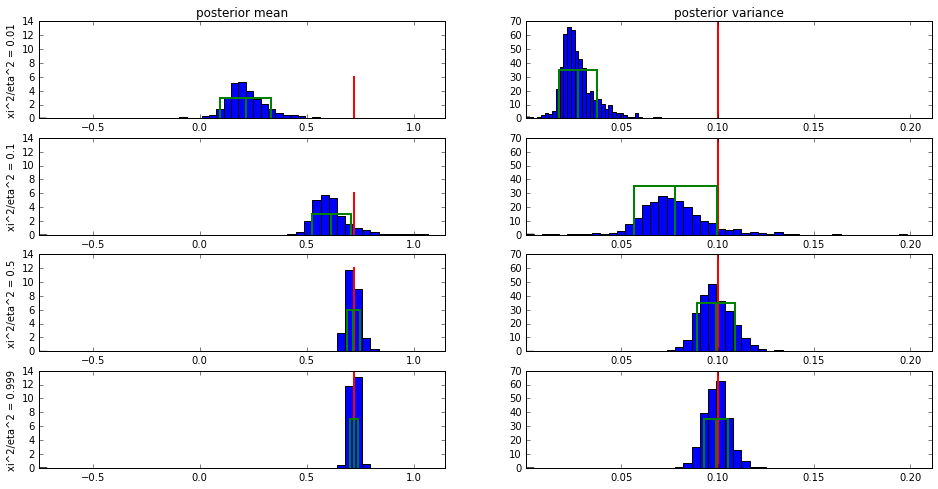

In [4]:
proposal_form = 'normal'
df = None

out_snpe  = res[proposal_form]

track_rp = True # track real posterior: if False, will compare with 'proposal-posterior'
plt.figure(figsize=(4*len(ksi2s),8))
m_m, m_v, M_m, M_v, hh_m, hh_v = np.inf,np.inf,-np.inf,-np.inf,-np.inf,-np.inf


for i in range(len(ksi2s)):
    
    nu, ksi2 = nus[i], ksi2s[i]
    
    if proposal_form == 'normal':
        ppr = dd.Gaussian(m=nu * np.ones(n_params), 
                        S=ksi2 * np.eye(n_params))
    elif proposal_form == 'studentT':
        ppr = dd.StudentsT(m=nu * np.ones(n_params), 
                           S=ksi2 * np.eye(n_params),
                           dof=df)    
    else:
        raise NotImplementedError
        
    postpr = dd.Gaussian(m = np.ones(n_params) * (ksi2/(ksi2+sig2)*x0[0] + sig2/(ksi2+sig2)*nu), 
                         S=ksi2 - ksi2**2 / (ksi2 + sig2) * np.eye(n_params))
    
    eta2p = 1/(1/eta2 - 1/ksi2)
    Sig_y = np.array([[eps2,0], [0,eta2p]])    
    mu_y = np.array([ [x0[0]], [eta2/(eta2-ksi2)*nu]])

    s = ds.Identity()
    g = dg.Default(model=m, prior=ppr, summary=s)
    pbar = progressbar(total=n_fits)
    desc = 'repeated fits'
    pbar.set_description(desc)
    with pbar:
        for idx_seed in range(n_fits):

            #print( str(idx_seed) + '/' + str(n_fits) )
            seed = 42 + idx_seed
            g.model.seed = seed
            g.prior.seed = seed
            g.seed = seed

            data = g.gen(N, verbose=False)
            params, stats = data[0].reshape(-1), data[1].reshape(-1)

            #normals = comp_weights(data[0], data[1], mu_y, Sig_y) if track_rp else np.ones(N)/N
            normals = get_weights(proposal_form, eta2, ksi2, eps2, x0, nu, stats, params, df=df) if track_rp else np.ones(N)/N
            ahat =       alpha(params, stats, normals)
            bhat =        beta(params, stats, normals, ahat)
            gamma2hat = gamma2(params, stats, normals, ahat, bhat)

            mu_hat   = ahat + bhat * x0
            sig2_hat = gamma2hat

            out_snpe[i,idx_seed,:] = (mu_hat, sig2_hat)
            pbar.update(1)

    post_disp = post if track_rp else postpr

    plt.subplot(len(ksi2s), 2, 2*i+1)
    m_m, M_m = np.min((m_m, out_snpe[i,:,0].min())), np.max((M_m, out_snpe[i,:,0].max()))
    plt.hist(out_snpe[i,:,0], bins=np.linspace(m_m, M_m, n_bins), normed=True)
    hh_m = np.max((hh_m, plt.axis()[3]))
    plt.plot([post_disp.mean, post_disp.mean], [0, hh_m], 'r', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([-1,-1]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([0,0]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([1,1]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([-1,1]), [ hh_m/2, hh_m/2], 'g', linewidth=2)
    plt.ylabel('xi^2/eta^2 = ' + str(ksi2/eta2) )
    
    plt.subplot(len(ksi2s),2, 2*i+2)
    m_v, M_v = np.min((m_v, out_snpe[i,:,1].min())), np.max((M_v, out_snpe[i,:,1].max()))
    plt.hist(out_snpe[i,:,1], bins=np.linspace(m_v, M_v, n_bins), normed=True)
    hh_v = np.max((hh_v, plt.axis()[3]))
    plt.plot([post_disp.std**2, post_disp.std**2], [0, hh_v], 'r', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([-1,-1]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([0,0]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([1,1]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([-1,1]), [ hh_v/2, hh_v/2], 'g', linewidth=2)
    #plt.ylabel('posterior variance')


plt.subplot(len(ksi2s),2,1)
plt.title('posterior mean')
plt.subplot(len(ksi2s),2,2)
plt.title('posterior variance')

for i in range(len(ksi2s)):
    plt.subplot(len(ksi2s),2, 2*i+1)
    plt.axis([m_m, M_m, 0, hh_m])
    plt.subplot(len(ksi2s),2, 2*i+2)
    plt.axis([m_v, M_v, 0, hh_v])
    
plt.savefig('example_hist_SNPE_normal_1000fits.pdf')    
    
plt.show()

# SNPE (students T proposals, df = 10) 
## multiple fits, with different proposal widths
- same as before, but with students T proposals instead of Gaussian proposals (same mean and variance)
- df $=10$ in 1D : roughly Gaussian, but with slightly stronger tails


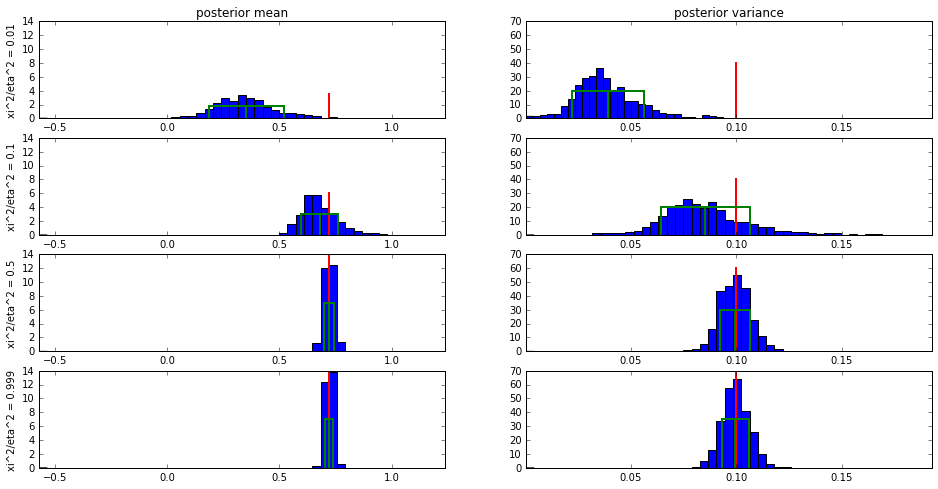

In [3]:
proposal_form = 'studentT'
df = 10

out_snpe  = res['t_df' + str(df)]

track_rp = True # track real posterior: if False, will compare with 'proposal-posterior'
plt.figure(figsize=(4*len(ksi2s),8))
m_m, m_v, M_m, M_v, hh_m, hh_v = np.inf,np.inf,-np.inf,-np.inf,-np.inf,-np.inf


for i in range(len(ksi2s)):
    
    nu, ksi2 = nus[i], ksi2s[i]
    
    if proposal_form == 'normal':
        ppr = dd.Gaussian(m=nu * np.ones(n_params), 
                        S=ksi2 * np.eye(n_params))
    elif proposal_form == 'studentT':
        ppr = dd.StudentsT(m=nu * np.ones(n_params), 
                           S=ksi2 * np.eye(n_params),
                           dof=df)    
    else:
        raise NotImplementedError
        
    postpr = dd.Gaussian(m = np.ones(n_params) * (ksi2/(ksi2+sig2)*x0[0] + sig2/(ksi2+sig2)*nu), 
                         S=ksi2 - ksi2**2 / (ksi2 + sig2) * np.eye(n_params))
    
    eta2p = 1/(1/eta2 - 1/ksi2)
    Sig_y = np.array([[eps2,0], [0,eta2p]])    
    mu_y = np.array([ [x0[0]], [eta2/(eta2-ksi2)*nu]])

    s = ds.Identity()
    g = dg.Default(model=m, prior=ppr, summary=s)
    pbar = progressbar(total=n_fits)
    desc = 'repeated fits'
    pbar.set_description(desc)
    with pbar:
        for idx_seed in range(n_fits):

            #print( str(idx_seed) + '/' + str(n_fits) )
            seed = 42 + idx_seed
            g.model.seed = seed
            g.prior.seed = seed
            g.seed = seed

            data = g.gen(N, verbose=False)
            params, stats = data[0].reshape(-1), data[1].reshape(-1)

            #normals = comp_weights(data[0], data[1], mu_y, Sig_y) if track_rp else np.ones(N)/N
            normals = get_weights(proposal_form, eta2, ksi2, eps2, x0, nu, stats, params, df=df) if track_rp else np.ones(N)/N
            ahat =       alpha(params, stats, normals)
            bhat =        beta(params, stats, normals, ahat)
            gamma2hat = gamma2(params, stats, normals, ahat, bhat)

            mu_hat   = ahat + bhat * x0
            sig2_hat = gamma2hat

            out_snpe[i,idx_seed,:] = (mu_hat, sig2_hat)
            pbar.update(1)

    post_disp = post if track_rp else postpr

    plt.subplot(len(ksi2s), 2, 2*i+1)
    m_m, M_m = np.min((m_m, out_snpe[i,:,0].min())), np.max((M_m, out_snpe[i,:,0].max()))
    plt.hist(out_snpe[i,:,0], bins=np.linspace(m_m, M_m, n_bins), normed=True)
    hh_m = np.max((hh_m, plt.axis()[3]))
    plt.plot([post_disp.mean, post_disp.mean], [0, hh_m], 'r', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([-1,-1]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([0,0]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([1,1]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([-1,1]), [ hh_m/2, hh_m/2], 'g', linewidth=2)
    plt.ylabel('xi^2/eta^2 = ' + str(ksi2/eta2) )
    
    plt.subplot(len(ksi2s),2, 2*i+2)
    m_v, M_v = np.min((m_v, out_snpe[i,:,1].min())), np.max((M_v, out_snpe[i,:,1].max()))
    plt.hist(out_snpe[i,:,1], bins=np.linspace(m_v, M_v, n_bins), normed=True)
    hh_v = np.max((hh_v, plt.axis()[3]))
    plt.plot([post_disp.std**2, post_disp.std**2], [0, hh_v], 'r', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([-1,-1]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([0,0]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([1,1]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([-1,1]), [ hh_v/2, hh_v/2], 'g', linewidth=2)
    #plt.ylabel('posterior variance')


plt.subplot(len(ksi2s),2,1)
plt.title('posterior mean')
plt.subplot(len(ksi2s),2,2)
plt.title('posterior variance')

for i in range(len(ksi2s)):
    plt.subplot(len(ksi2s),2, 2*i+1)
    plt.axis([m_m, M_m, 0, hh_m])
    plt.subplot(len(ksi2s),2, 2*i+2)
    plt.axis([m_v, M_v, 0, hh_v])
    
plt.show()

# SNPE (students T proposals, df = 3) 
## multiple fits, with different proposal widths
- same as before, but with students T proposals instead of Gaussian proposals (same mean and variance)
- df $=3$ in 1D : much stronger tails than Gaussian (need df>2 for well-defined student-T variance)


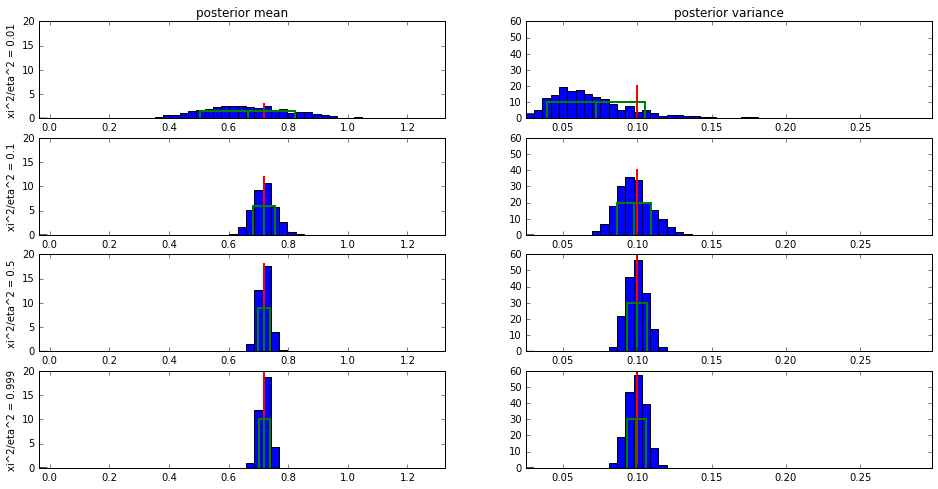

In [4]:
proposal_form = 'studentT'
df = 3

out_snpe  = res['t_df' + str(df)]

track_rp = True # track real posterior: if False, will compare with 'proposal-posterior'
plt.figure(figsize=(4*len(ksi2s),8))
m_m, m_v, M_m, M_v, hh_m, hh_v = np.inf,np.inf,-np.inf,-np.inf,-np.inf,-np.inf


for i in range(len(ksi2s)):
    
    nu, ksi2 = nus[i], ksi2s[i]
    
    if proposal_form == 'normal':
        ppr = dd.Gaussian(m=nu * np.ones(n_params), 
                        S=ksi2 * np.eye(n_params))
    elif proposal_form == 'studentT':
        ppr = dd.StudentsT(m=nu * np.ones(n_params), 
                           S=ksi2 * np.eye(n_params),
                           dof=df)    
    else:
        raise NotImplementedError
        
    postpr = dd.Gaussian(m = np.ones(n_params) * (ksi2/(ksi2+sig2)*x0[0] + sig2/(ksi2+sig2)*nu), 
                         S=ksi2 - ksi2**2 / (ksi2 + sig2) * np.eye(n_params))
    
    eta2p = 1/(1/eta2 - 1/ksi2)
    Sig_y = np.array([[eps2,0], [0,eta2p]])    
    mu_y = np.array([ [x0[0]], [eta2/(eta2-ksi2)*nu]])

    s = ds.Identity()
    g = dg.Default(model=m, prior=ppr, summary=s)
    pbar = progressbar(total=n_fits)
    desc = 'repeated fits'
    pbar.set_description(desc)
    with pbar:
        for idx_seed in range(n_fits):

            #print( str(idx_seed) + '/' + str(n_fits) )
            seed = 42 + idx_seed
            g.model.seed = seed
            g.prior.seed = seed
            g.seed = seed

            data = g.gen(N, verbose=False)
            params, stats = data[0].reshape(-1), data[1].reshape(-1)

            #normals = comp_weights(data[0], data[1], mu_y, Sig_y) if track_rp else np.ones(N)/N
            normals = get_weights(proposal_form, eta2, ksi2, eps2, x0, nu, stats, params, df=df) if track_rp else np.ones(N)/N
            ahat =       alpha(params, stats, normals)
            bhat =        beta(params, stats, normals, ahat)
            gamma2hat = gamma2(params, stats, normals, ahat, bhat)

            mu_hat   = ahat + bhat * x0
            sig2_hat = gamma2hat

            out_snpe[i,idx_seed,:] = (mu_hat, sig2_hat)
            pbar.update(1)

    post_disp = post if track_rp else postpr

    plt.subplot(len(ksi2s), 2, 2*i+1)
    m_m, M_m = np.min((m_m, out_snpe[i,:,0].min())), np.max((M_m, out_snpe[i,:,0].max()))
    plt.hist(out_snpe[i,:,0], bins=np.linspace(m_m, M_m, n_bins), normed=True)
    hh_m = np.max((hh_m, plt.axis()[3]))
    plt.plot([post_disp.mean, post_disp.mean], [0, hh_m], 'r', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([-1,-1]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([0,0]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([1,1]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([-1,1]), [ hh_m/2, hh_m/2], 'g', linewidth=2)
    plt.ylabel('xi^2/eta^2 = ' + str(ksi2/eta2) )
    
    plt.subplot(len(ksi2s),2, 2*i+2)
    m_v, M_v = np.min((m_v, out_snpe[i,:,1].min())), np.max((M_v, out_snpe[i,:,1].max()))
    plt.hist(out_snpe[i,:,1], bins=np.linspace(m_v, M_v, n_bins), normed=True)
    hh_v = np.max((hh_v, plt.axis()[3]))
    plt.plot([post_disp.std**2, post_disp.std**2], [0, hh_v], 'r', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([-1,-1]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([0,0]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([1,1]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([-1,1]), [ hh_v/2, hh_v/2], 'g', linewidth=2)
    #plt.ylabel('posterior variance')


plt.subplot(len(ksi2s),2,1)
plt.title('posterior mean')
plt.subplot(len(ksi2s),2,2)
plt.title('posterior variance')

for i in range(len(ksi2s)):
    plt.subplot(len(ksi2s),2, 2*i+1)
    plt.axis([m_m, M_m, 0, hh_m])
    plt.subplot(len(ksi2s),2, 2*i+2)
    plt.axis([m_v, M_v, 0, hh_v])
plt.show()

# compare with CDELFI
- simply set track_rp = False to compare MLE solution with mean and variance of proposal-posterior
- however requires Gaussian proposals to directly compare with proposal-posterior
- if the proposal-posterior is good, so should be the prior-corrected result of the analytical division
- todo: import and use code for analyical division

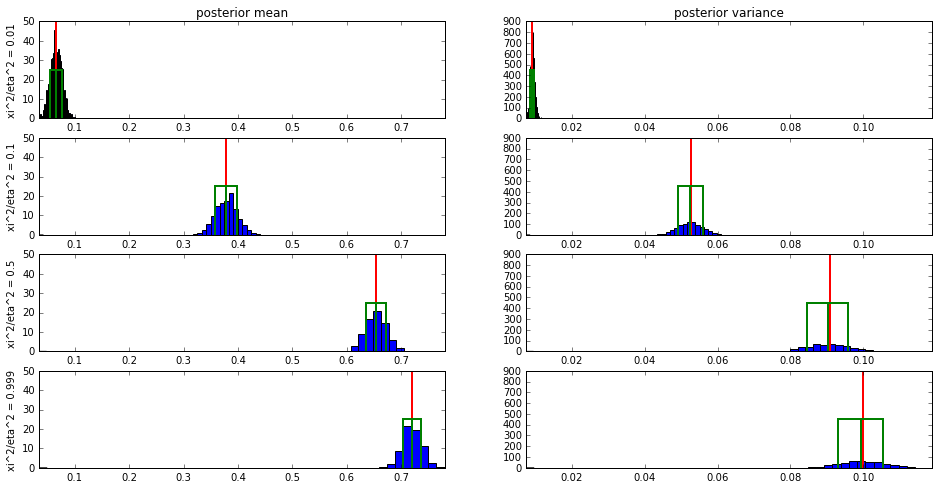

In [5]:
proposal_form = 'normal'
df = None

out_snpe  = res['cdelfi']

track_rp = False # track real posterior: if False, will compare with 'proposal-posterior'
plt.figure(figsize=(4*len(ksi2s),8))
m_m, m_v, M_m, M_v, hh_m, hh_v = np.inf,np.inf,-np.inf,-np.inf,-np.inf,-np.inf


for i in range(len(ksi2s)):
    
    nu, ksi2 = nus[i], ksi2s[i]
    
    if proposal_form == 'normal':
        ppr = dd.Gaussian(m=nu * np.ones(n_params), 
                        S=ksi2 * np.eye(n_params))
    elif proposal_form == 'studentT':
        ppr = dd.StudentsT(m=nu * np.ones(n_params), 
                           S=ksi2 * np.eye(n_params),
                           dof=df)    
    else:
        raise NotImplementedError
        
    postpr = dd.Gaussian(m = np.ones(n_params) * (ksi2/(ksi2+sig2)*x0[0] + sig2/(ksi2+sig2)*nu), 
                         S=ksi2 - ksi2**2 / (ksi2 + sig2) * np.eye(n_params))
    
    eta2p = 1/(1/eta2 - 1/ksi2)
    Sig_y = np.array([[eps2,0], [0,eta2p]])    
    mu_y = np.array([ [x0[0]], [eta2/(eta2-ksi2)*nu]])

    s = ds.Identity()
    g = dg.Default(model=m, prior=ppr, summary=s)
    pbar = progressbar(total=n_fits)
    desc = 'repeated fits'
    pbar.set_description(desc)
    with pbar:
        for idx_seed in range(n_fits):

            #print( str(idx_seed) + '/' + str(n_fits) )
            seed = 42 + idx_seed
            g.model.seed = seed
            g.prior.seed = seed
            g.seed = seed

            data = g.gen(N, verbose=False)
            params, stats = data[0].reshape(-1), data[1].reshape(-1)

            #normals = comp_weights(data[0], data[1], mu_y, Sig_y) if track_rp else np.ones(N)/N
            normals = get_weights(proposal_form, eta2, ksi2, eps2, x0, nu, stats, params, df=df) if track_rp else np.ones(N)/N
            ahat =       alpha(params, stats, normals)
            bhat =        beta(params, stats, normals, ahat)
            gamma2hat = gamma2(params, stats, normals, ahat, bhat)

            mu_hat   = ahat + bhat * x0
            sig2_hat = gamma2hat

            out_snpe[i,idx_seed,:] = (mu_hat, sig2_hat)
            pbar.update(1)

    post_disp = post if track_rp else postpr

    plt.subplot(len(ksi2s), 2, 2*i+1)
    m_m, M_m = np.min((m_m, out_snpe[i,:,0].min())), np.max((M_m, out_snpe[i,:,0].max()))
    plt.hist(out_snpe[i,:,0], bins=np.linspace(m_m, M_m, n_bins), normed=True)
    hh_m = np.max((hh_m, plt.axis()[3]))
    plt.plot([post_disp.mean, post_disp.mean], [0, hh_m], 'r', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([-1,-1]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([0,0]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([1,1]), [0, hh_m/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,0].mean() + out_snpe[i,:,0].std()*np.array([-1,1]), [ hh_m/2, hh_m/2], 'g', linewidth=2)
    plt.ylabel('xi^2/eta^2 = ' + str(ksi2/eta2) )
    
    plt.subplot(len(ksi2s),2, 2*i+2)
    m_v, M_v = np.min((m_v, out_snpe[i,:,1].min())), np.max((M_v, out_snpe[i,:,1].max()))
    plt.hist(out_snpe[i,:,1], bins=np.linspace(m_v, M_v, n_bins), normed=True)
    hh_v = np.max((hh_v, plt.axis()[3]))
    plt.plot([post_disp.std**2, post_disp.std**2], [0, hh_v], 'r', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([-1,-1]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([0,0]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([1,1]), [0, hh_v/2], 'g', linewidth=2)
    plt.plot(out_snpe[i,:,1].mean() + out_snpe[i,:,1].std()*np.array([-1,1]), [ hh_v/2, hh_v/2], 'g', linewidth=2)
    #plt.ylabel('posterior variance')


plt.subplot(len(ksi2s),2,1)
plt.title('posterior mean')
plt.subplot(len(ksi2s),2,2)
plt.title('posterior variance')

for i in range(len(ksi2s)):
    plt.subplot(len(ksi2s),2, 2*i+1)
    plt.axis([m_m, M_m, 0, hh_m])
    plt.subplot(len(ksi2s),2, 2*i+2)
    plt.axis([m_v, M_v, 0, hh_v])
    
plt.savefig('example_hist_CDELFI_normal_1000fits.pdf')    
    
plt.show()

In [ ]:

np.save('res_analytic_n_fits' + str(n_fits) + '_N' + str(N), res)


# summary figures

## biases

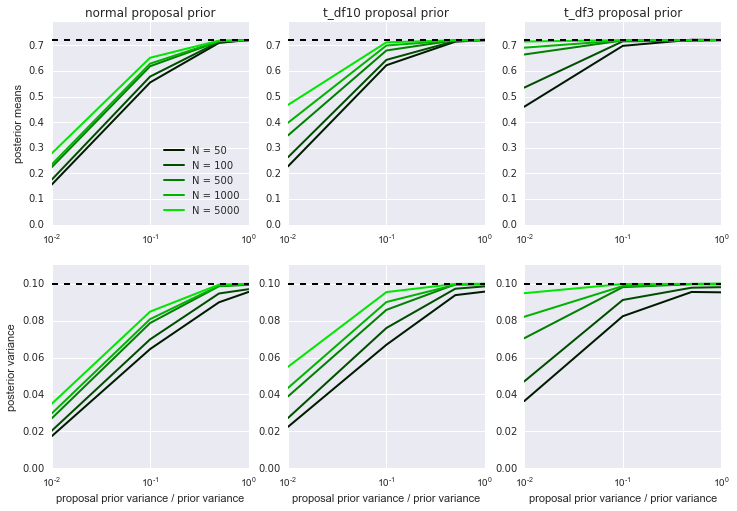

In [5]:
%matplotlib inline
import numpy as np
import seaborn
import matplotlib.pyplot as plt


Ns = [ 50, 100, 500, 1000, 5000 ]
n_fits = 1000

plt.figure(figsize=(12, 8))
clrs = np.array([[0,1,0]]) * np.linspace(0.1, 0.9, len(Ns)).reshape(-1,1)
algs = ['normal', 't_df10', 't_df3']

#mkrs, algs = mkrs[:3], algs[:3]


for i in range(len(algs)):
    
    alg = algs[i]
    
    
    for n in range(len(Ns)):

        N = Ns[n]
        clr = clrs[n]
        
        tmp = np.load('res_analytic_n_fits' + str(n_fits) + '_N' + str(N)+'.npy')[()]        
        out_snpe = tmp[alg]

        plt.subplot(2,len(algs),i+1)

        if alg == 'cdelfi' : 
            m = analytic_div(out_snpe, eta2, nu*np.ones_like(ksi2s), ksi2s)[:,:,0].mean(axis=1)
        else:
            m = out_snpe[:,:,0].mean(axis=1)
        plt.semilogx(ksi2s, m, color=clr, linewidth=2)
        plt.title(alg + ' proposal prior')
        
        plt.subplot(2,len(algs),i+1+len(algs))
        
        if alg == 'cdelfi' : 
            m = analytic_div(out_snpe, eta2, nu*np.ones_like(ksi2s), ksi2s)[:,:,1].mean(axis=1)
        else:
            m = out_snpe[:,:,1].mean(axis=1)
        plt.semilogx(ksi2s, m, color=clr, linewidth=2)

    for n in range(len(Ns)):

        N = Ns[n]
        clr = clrs[n]
        
        ksi2s = tmp['ksi2s']
        eta2, sig2, x0 = tmp['eta2'], tmp['sig2'], tmp['x0']
        
        plt.subplot(2,len(algs),i+1)

        gt = eta2/(eta2+sig2)*x0[0]*np.ones_like(ksi2s)    
        plt.semilogx(ksi2s, gt*np.ones_like(ksi2s), 'k--', linewidth=2)
        
        plt.subplot(2,len(algs),i+1+len(algs))

        gt = eta2 - eta2**2 / (eta2 + sig2)
        plt.semilogx(ksi2s, gt*np.ones_like(ksi2s), 'k--', linewidth=2)
        
for i in range(len(algs)):
    plt.subplot(2,len(algs),i+1)
    plt.axis([ksi2s[0], ksi2s[-1], 0, 1.1*eta2/(eta2+sig2)*x0[0]])
    plt.subplot(2,len(algs),i+1+len(algs))
    plt.axis([ksi2s[0], ksi2s[-1], 0, 1.1*(eta2 - eta2**2 / (eta2 + sig2))])
    plt.xlabel('proposal prior variance / prior variance') 
    
plt.subplot(2,len(algs),1)
plt.ylabel('posterior means')
plt.legend(['N = ' + str(n) for n in Ns], loc=4)
plt.subplot(2,len(algs),len(algs)+1)
plt.ylabel('posterior variance')

plt.savefig('bias_1000fits_SNPE.pdf')
plt.show()

## estimator standard deviations

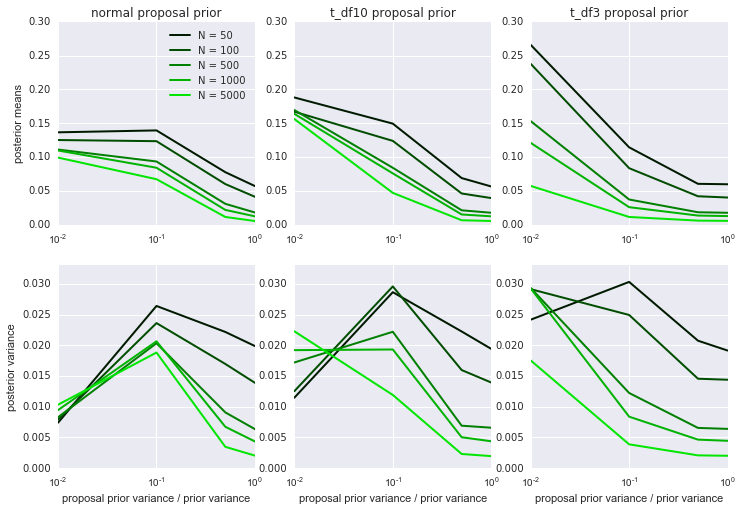

In [6]:
%matplotlib inline
import numpy as np
import seaborn
import matplotlib.pyplot as plt


Ns = [ 50, 100, 500, 1000, 5000 ]
n_fits = 1000

plt.figure(figsize=(12, 8))
clrs = np.array([[0,1,0]]) * np.linspace(0.1, 0.9, len(Ns)).reshape(-1,1)
algs = ['normal', 't_df10', 't_df3']

#mkrs, algs = mkrs[:3], algs[:3]


for i in range(len(algs)):
    
    alg = algs[i]
    
    for n in range(len(Ns)):

        N = Ns[n]
        clr = clrs[n]
        
        tmp = np.load('res_analytic_n_fits' + str(n_fits) + '_N' + str(N)+'.npy')[()]        
        out_snpe = tmp[alg]

        plt.subplot(2, len(algs),i+1)

        if alg == 'cdelfi' : 
            s = analytic_div(out_snpe, eta2, nu*np.ones_like(ksi2s), ksi2s)[:,:,0].std(axis=1)
        else:
            s = out_snpe[:,:,0].std(axis=1)
        plt.semilogx(ksi2s, s, color=clr, linewidth=2)
        plt.title(alg + ' proposal prior')
        
        plt.subplot(2,len(algs),i+1+len(algs))
        
        if alg == 'cdelfi' : 
            s = analytic_div(out_snpe, eta2, nu*np.ones_like(ksi2s), ksi2s)[:,:,1].std(axis=1)
        else:
            s = out_snpe[:,:,1].std(axis=1)
        plt.semilogx(ksi2s, s, color=clr, linewidth=2)

        
for i in range(len(algs)):
    plt.subplot(2, len(algs), i+1)
    plt.axis([ksi2s[0], ksi2s[-1], 0, 0.3])
    plt.subplot(2,len(algs),len(algs)+1+i)
    plt.axis([ksi2s[0], ksi2s[-1], 0, 0.033])
    plt.xlabel('proposal prior variance / prior variance') 
    
plt.subplot(2,len(algs),1)
plt.ylabel('posterior means')
plt.legend(['N = ' + str(n) for n in Ns], loc=1)
plt.subplot(2,len(algs),len(algs)+1)
plt.ylabel('posterior variance')

plt.savefig('std_1000fits_SNPE.pdf')
plt.show()

# another look at CDELFI in 'proposal prior'-space
## Gaussian priors, no analytical division, no importance sampling

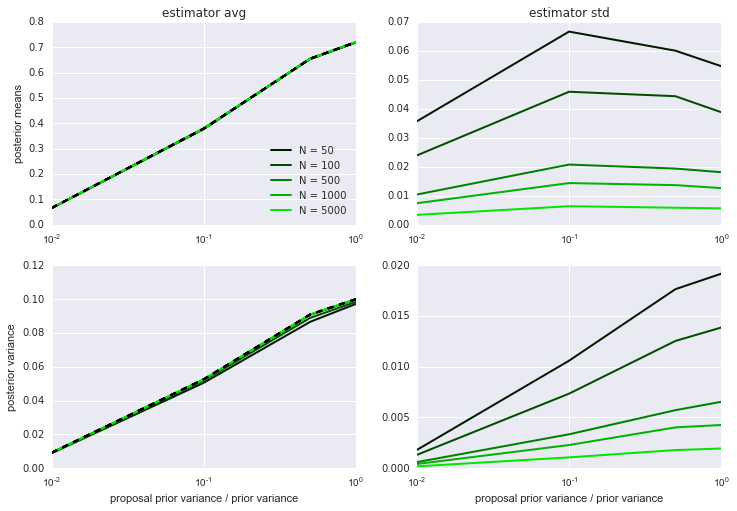

In [7]:
%matplotlib inline
import numpy as np
import seaborn
import matplotlib.pyplot as plt


Ns = [ 50, 100, 500, 1000, 5000 ]
n_fits = 1000

plt.figure(figsize=(12, 8))
clrs = np.array([[0,1,0]]) * np.linspace(0.1, 0.9, len(Ns)).reshape(-1,1)
    
for n in range(len(Ns)):

    N = Ns[n]
    clr = clrs[n]

    tmp = np.load('res_analytic_n_fits' + str(n_fits) + '_N' + str(N)+'.npy')[()]        
    out_snpe = tmp['cdelfi']

    plt.subplot(2,2,1)

    m = out_snpe[:,:,0].mean(axis=1)
    plt.semilogx(ksi2s, m, color=clr, linewidth=2)

    plt.subplot(2,2,3)

    m = out_snpe[:,:,1].mean(axis=1)
    plt.semilogx(ksi2s, m, color=clr, linewidth=2)

    plt.subplot(2,2,2)

    s = out_snpe[:,:,0].std(axis=1)
    plt.semilogx(ksi2s, s, color=clr, linewidth=2)

    plt.subplot(2,2,4)
    s = out_snpe[:,:,1].std(axis=1)
    plt.semilogx(ksi2s, s, color=clr, linewidth=2)
    
    
for n in range(len(Ns)):

    N = Ns[n]
    clr = clrs[n]

    ksi2s = tmp['ksi2s']
    eta2, sig2, x0 = tmp['eta2'], tmp['sig2'], tmp['x0']

    plt.subplot(2,2,1)

    gt = ksi2s/(ksi2s+sig2)*x0[0]    
    plt.semilogx(ksi2s, gt, 'k--', linewidth=2)

    plt.subplot(2,2,3)

    gt = ksi2s - ksi2s**2 / (ksi2s + sig2)
    plt.semilogx(ksi2s, gt, 'k--', linewidth=2)
            
plt.subplot(2,2,1)
plt.ylabel('posterior means')
plt.title('estimator avg')
plt.legend(['N = ' + str(n) for n in Ns], loc=4)
plt.subplot(2,2,3)
plt.ylabel('posterior variance')
plt.xlabel('proposal prior variance / prior variance')
plt.subplot(2,2,2)
plt.title('estimator std')
plt.subplot(2,2,4)
plt.xlabel('proposal prior variance / prior variance') 

plt.savefig('bias_std_1000fits_CDELFI.pdf')

plt.show()

# numberical checks for gradients


In [31]:
N = 3
track_rp = True
proposal_form = 'normal'
df = None

nu = 0.
ksi2 = 0.5 * eta2

ppr = dd.Gaussian(m=nu * np.ones(n_params), 
                S=ksi2 * np.eye(n_params))
s = ds.Identity()
g = dg.Default(model=m, prior=ppr, summary=s)

seed = 42
g.model.seed = seed
g.prior.seed = seed
g.seed = seed

data = g.gen(N, verbose=False)
params, stats = data[0].reshape(-1), data[1].reshape(-1)

normals = get_weights(proposal_form, eta2, ksi2, eps2, x0, nu, stats, params, df=df) if track_rp else np.ones(N)/N


# numerically check $\frac{\partial}{\partial{}\alpha}$

- $\frac{\partial}{\partial\alpha}$ is being difficult here. Analytic solution $\hat{\alpha}$ still fails to numberically set the stated partial derivative $\frac{\partial\mathcal{L}}{\partial{}\alpha}(\hat{\alpha})$ to zero ...
- Obtained $\hat{\alpha}$ however are pretty much sensible though (correct 'ballpark')

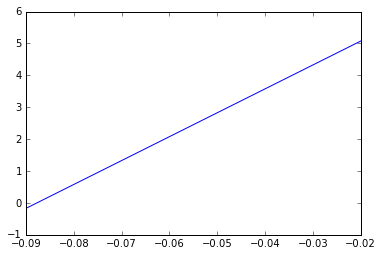

(-0.087714477144771444, array(-0.08771414546194997), array([ -8.88178420e-16]))

In [36]:
alpha_hat = np.array(alpha(params, stats, normals))

gamma2_ = post.std**2
alphas = np.linspace(-0.09, -0.02, 100000)

beta_ = beta(params, stats, normals, alpha_hat)
out_hat = -2*(normals.reshape(-1,1) * (params.reshape(-1,1) - beta_ * stats.reshape(-1,1) - alpha_hat)/gamma2_).sum(axis=0)
out = -2*(normals.reshape(-1,1) * (params.reshape(-1,1) - beta_ * stats.reshape(-1,1) - alphas.reshape(1,-1))/gamma2_).sum(axis=0)
plt.plot(alphas, out)
plt.show()


# (numerical solution, analytical solution, derivate evaluated at analytical solution (should be zero-ish) ) = 
alphas[np.argmin(np.abs(out))], alpha_hat, out_hat

# numerically check $\frac{\partial}{\partial{}\beta}$

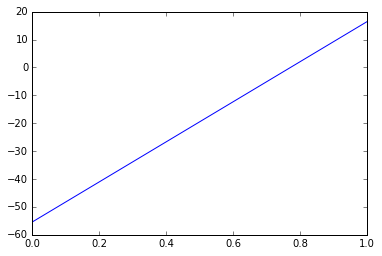

(0.77177177177177181, 0.77131848111585577, array([ -3.55271368e-15]))

In [43]:
alpha_ = alpha_hat
gamma2_ = post.std**2
betas = np.linspace(0., 1., 1000)
out = -2*(normals.reshape(-1,1) * (params.reshape(-1,1) - betas.reshape(1,-1) * stats.reshape(-1,1) - alpha_)/gamma2_ * stats.reshape(-1,1)).sum(axis=0)
plt.plot(betas, out)
plt.show()

beta_hat = beta(params, stats, normals, ahat=alpha_)
out_hat = -2*(normals.reshape(-1,1) * (params.reshape(-1,1) - beta_hat * stats.reshape(-1,1) - alpha_)/gamma2_ * stats.reshape(-1,1)).sum(axis=0)

# (numerical solution, analytical solution, derivate evaluated at analytical solution (should be zero-ish) ) = 
betas[np.argmin(np.abs(out))], beta_hat, out_hat

# numerically check $\frac{\partial}{\partial{}\gamma^2}$

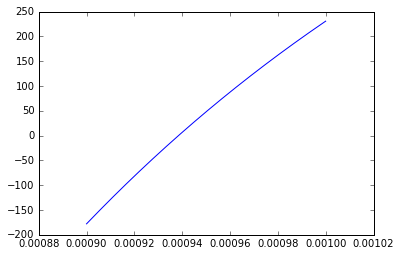

(0.00093843843843843843, 0.00093844888309603503, array([ -1.04107563e-11]))

In [48]:
alpha_ = alpha_hat
beta_ = beta_hat
gamma2s = np.linspace(0.0009, 0.001, 1000)

# something off with below (hard-coded...) gradients now. Outcommenting numerical solution for now!

tmp = (params.reshape(-1,1) - beta_*stats.reshape(-1,1) - alpha_)**2 / gamma2s.reshape(1,-1)
out = 1/gamma2s.reshape(-1,) * (normals.reshape(-1,1) * (1 - tmp)).sum(axis=0)

plt.plot(gamma2s, out)
plt.show()

gamma2_hat = gamma2(params, stats, normals, ahat=alpha_, bhat=beta_)
tmp_ = (params.reshape(-1,1) - beta_*stats.reshape(-1,1) - alpha_)**2 / gamma2_hat
out_hat = 1/gamma2_hat * (normals.reshape(-1,1) * (1 - tmp_)).sum(axis=0)

#gamma2s *= np.nan 
#out = np.zeros_like(gamma2s)

# (numerical solution, analytical solution, derivate evaluated at analytical solution (should be zero-ish) ) = 
gamma2s[np.argmin(np.abs(out))], gamma2_hat, out_hat